In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# 단일/여러 그래프를 plot하기.
def plot_series(time, series, format="-", start=0, end = None, label = None):
    plt.figure(figsize=(10, 6))
    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start : end], series_num[start : end], format)
    else:
      plt.plot(time[start:end], series[start:end], format)
    if label: plt.legend(fontsize=14, labels=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

# time 동안 기울기 slope인 series 생성
def trend(time, slope=0): return slope * time

# season_time 값이 0.4 미만이면 주기를 곱해서 반환, 아니면 지수함수 반환
def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))    
    return data_pattern

# 전체 값, 주기, 진폭, 이동
def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

# 전체 값, 노이즈 정도, 시드
def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level    
    return noise

# 자기 상관 그래프 생성
def autocorrelation(time, amplitude, seed=None):
    rnd = np.random.RandomState(seed)    
    # 랜덤 초기화
    ar = rnd.randn(len(time) + 50)
    # 앞부분 상수 생성
    ar[:50] = 100
    phi1 = 0.5
    phi2 = -0.1
    # 자기 상관 넣기 
    for step in range(50, len(time) + 50):
        ar[step] += phi1 * ar[step - 50]
        ar[step] += phi2 * ar[step - 33]
    # 앞부분 자르기
    ar = ar[50:] * amplitude
    return ar

# 임펄스 갯수를 지정해서 주입
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)  
    impulse_indices = rnd.randint(len(time), size=num_impulses)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

# 자기 상관이 있는 임펄스 파장..
def autocorrelation_impulses(source, phis):
    ar = source.copy()
    for step, value in enumerate(source):
        for lag, phi in phis.items():
            if step - lag > 0:
              ar[step] += phi * ar[step - lag]
    return ar

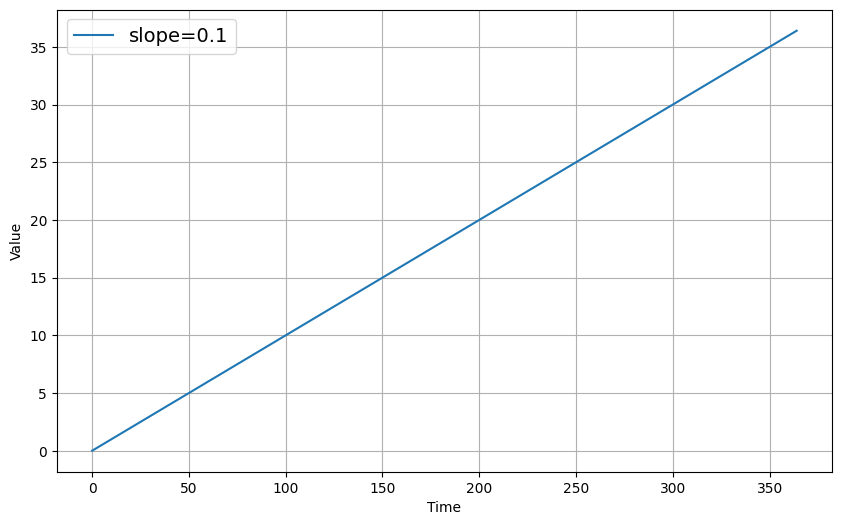

In [7]:
# trend 넣기
time = np.arange(365)
series = trend(time, 0.1 )
plot_series(time, series, label=[f'slope={0.1}'])

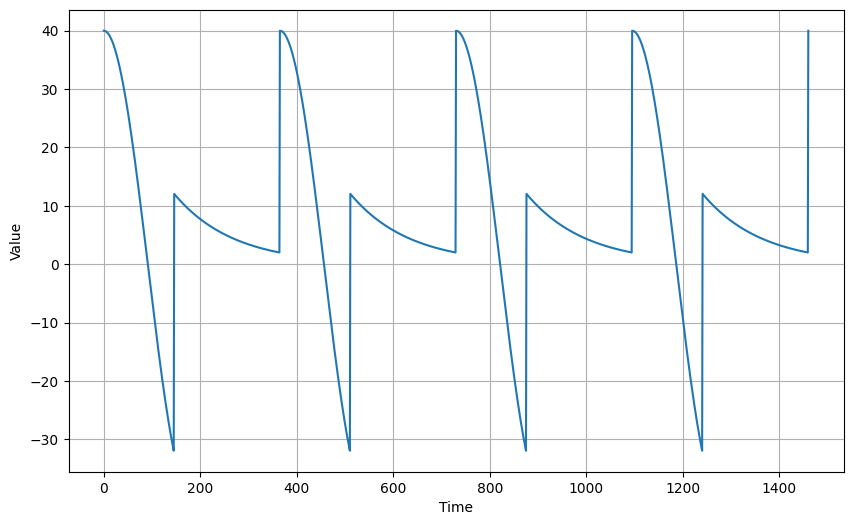

In [9]:
# seasonality 넣기
time = np.arange(4 * 365 + 1)
period = 365
amplitude = 40
series = seasonality(time, period=period, amplitude=amplitude, phase = 0)
plot_series(time, series)

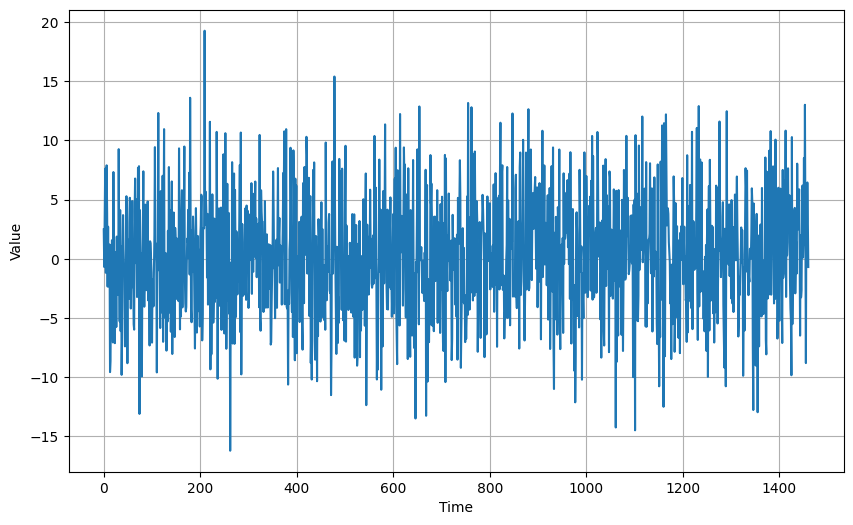

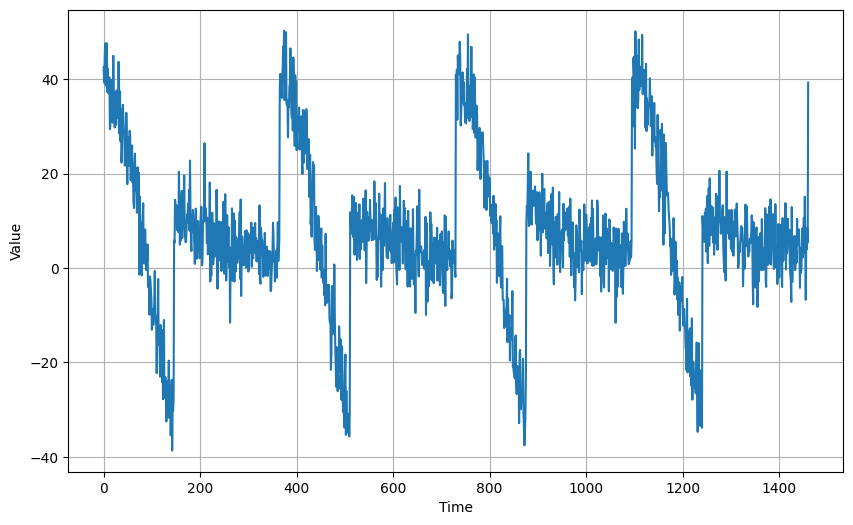

In [10]:
# 노이즈 확인하고, 넣기.
noise_level = 5
noise_signal = noise(time, noise_level=noise_level, seed=42)
plot_series(time, noise_signal)
series += noise_signal
plot_series(time, series)

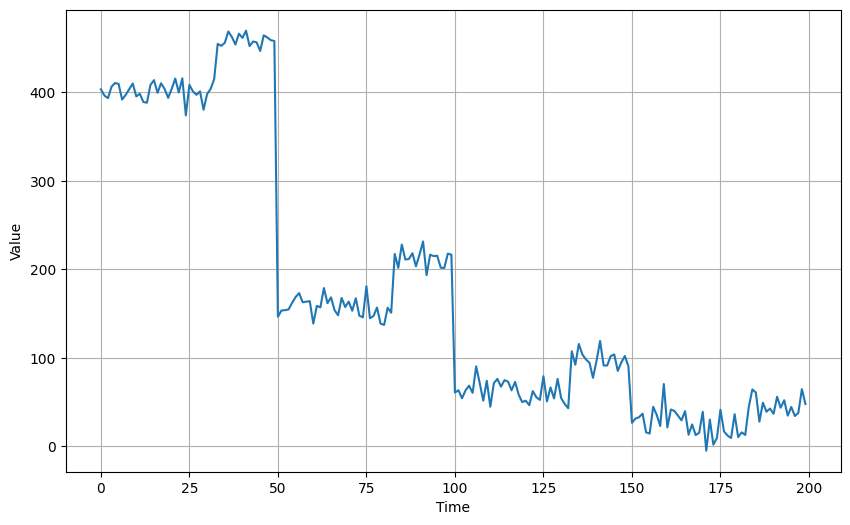

In [11]:
# 자기 상관 그래프
series = autocorrelation(time, amplitude=10, seed=42)
plot_series(time[:200], series[:200])

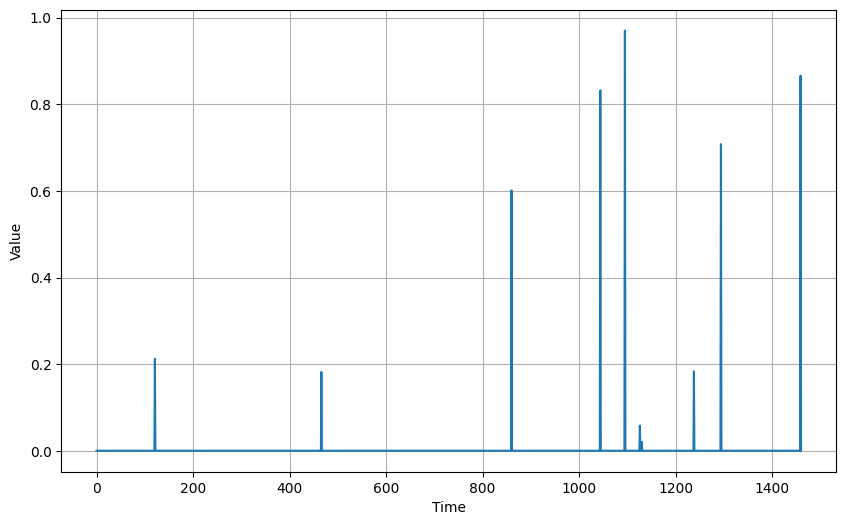

In [12]:
# 임펄스 파장
impulses_signal = impulses(time, num_impulses=10, seed=42)
plot_series(time, impulses_signal)

In [13]:
# 자기 상관이 있는 임펄스 파장..
def autocorrelation_impulses(source, phis):
    ar = source.copy()
    for step, value in enumerate(source):
        for lag, phi in phis.items():
            if step - lag > 0:
              ar[step] += phi * ar[step - lag]
    return ar

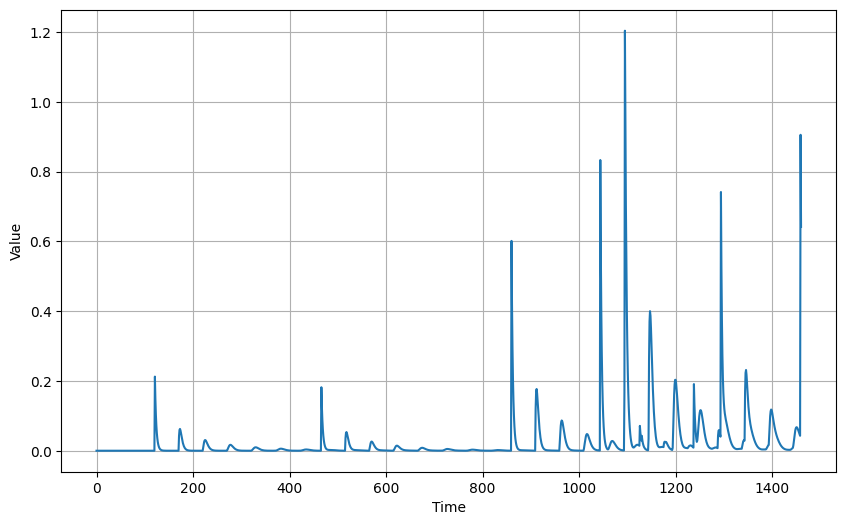

In [14]:
# 자기 상관이 있는 임펄스 파장. 즉 임펄스 이후에 여파가 있는 놈... 
# series = autocorrelation_impulses(impulses_signal, {1: 0.99})
series = autocorrelation_impulses(impulses_signal, {1: 0.70, 50: 0.2})
plot_series(time, series)

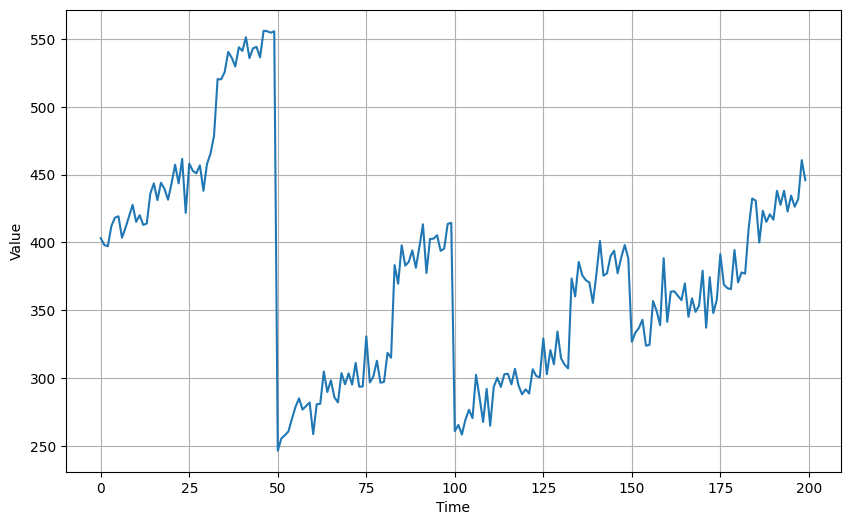

In [15]:
# 자기 상관과 트랜드
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])

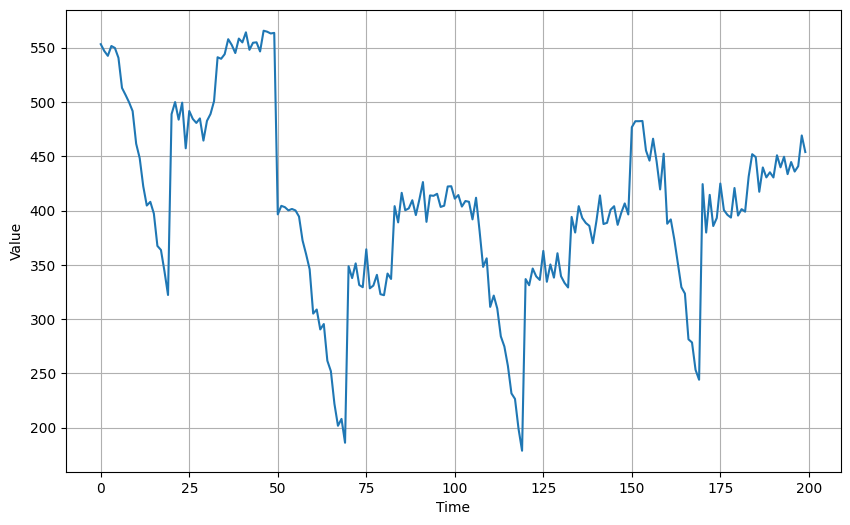

In [16]:
# 자기상관과 시즈널리티 트랜드
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])

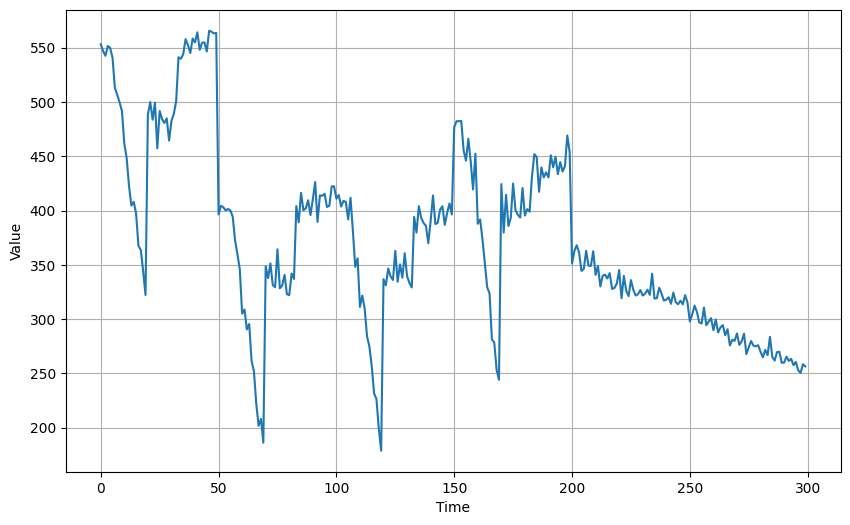

In [17]:
# 여러 시리즈를 합쳐서..
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
plot_series(time[:300], series[:300])

lab2

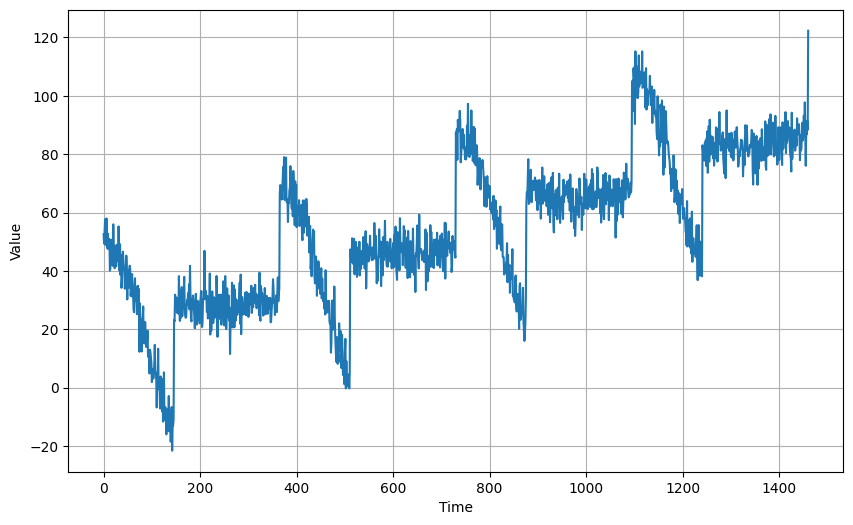

In [18]:
# 그래프 하나 만들어보자.
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)
plot_series(time, series)

In [19]:
len(time)

1461

AI에서는 다음과 같이 val, test를 구분해서 나누는 것이 일반적.

![](./fixed_partitioning.png)

하지만 위와 같이 구성하면 테스트 데이터는 현재값을 예측할 수 있는 가장 유력한 값이기 때문에, 훈련에 안쓰고 테스트만로 쓰기 아깝다... 

val과 test를 구분하지 않고 학습하기도 한다.

epoch마다 훈련기간을 늘리면 롤 포워드 파티셔닝이라고 한다.

 

In [20]:
# 대충 1000에서 끊어주고, 
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

# plot_series(time_train, x_train)
# plot_series(time_valid, x_valid)

### 2-1. Naive

- 바로 전날 값으로 예측... 의미는 없지만, MSE, MAE를 구하기 위해 해보자. 

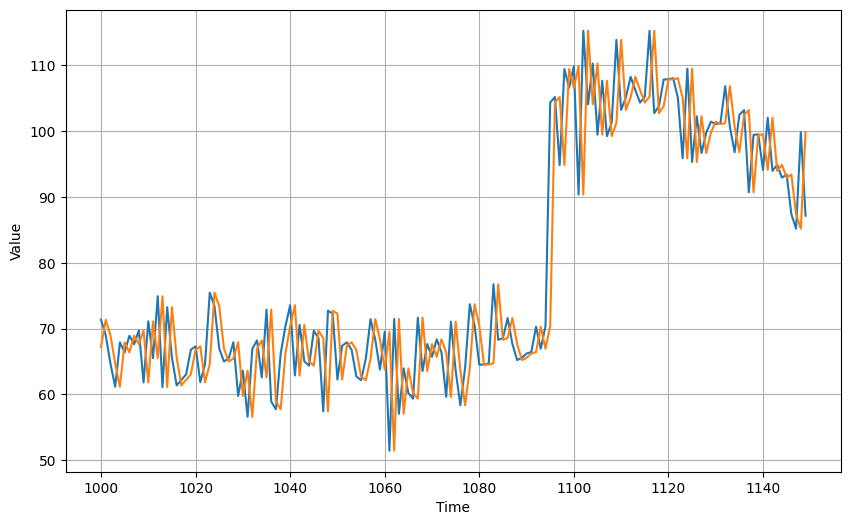

In [21]:
# 그냥 그래프를 평행이동한 거랑 똑같다.
naive_forecast = series[split_time - 1:-1]
# plot_series(time_valid, (x_valid, naive_forecast)) # 두 개 띄워보기
plot_series(time_valid, (x_valid, naive_forecast), start=0, end=150) # 줌해서 봐보자.


In [22]:
# 보통 MSE, MAE가 지표가 됨.
# 예측 모델을 썼는데 이거보다 안좋으면 사실 의미가 없다.
print(tf.keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827526
5.9379086


### 2-2. Moving Average

- 평균 이동법, 꽤 많이 쓰이는 기법이다. 바로 전 일정 기간의 평균으로 예측하는 법.

In [23]:
# 이전 window_size 기간 만큼의 mean으로 채워나간다.
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())
    forecast = np.array(forecast)
    return forecast

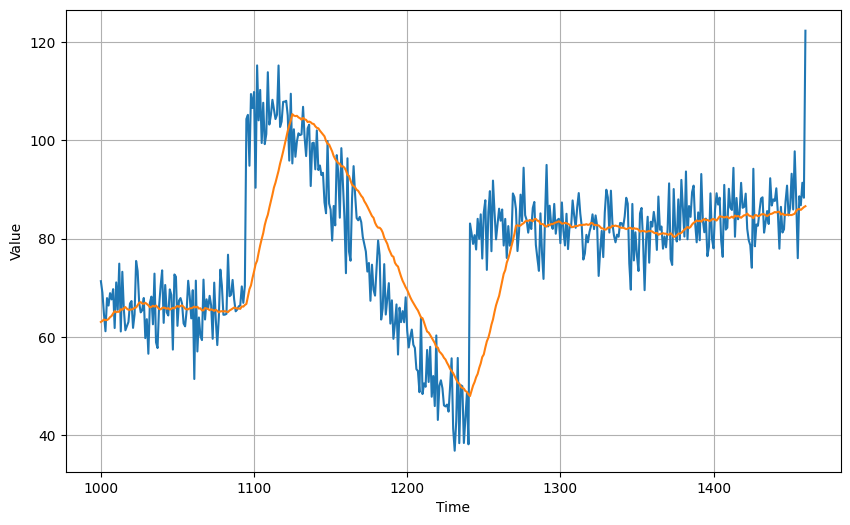

In [24]:
# 평균을 가져다 쓰기 때문에 noise와 impluse에 민감하지 않다. 
# noise는 무시해서 좋지만 impluse는 무시하면 좀 위험해보인다.
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
plot_series(time_valid, (x_valid, moving_avg))

In [25]:
# 의외로 Naive가 더 좋다.
print(tf.keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

106.67457
7.142419


### 2-3. Differencing

차분법.. 계절성과 추세는 과거를 그대로 반영하고, 그 외에 것을 이동 평균 취해서 더해준다.

패턴은 반영되고 잔차가 줄어드는 꼴. 주기를 정확하게 알아야 쓸만 하다.

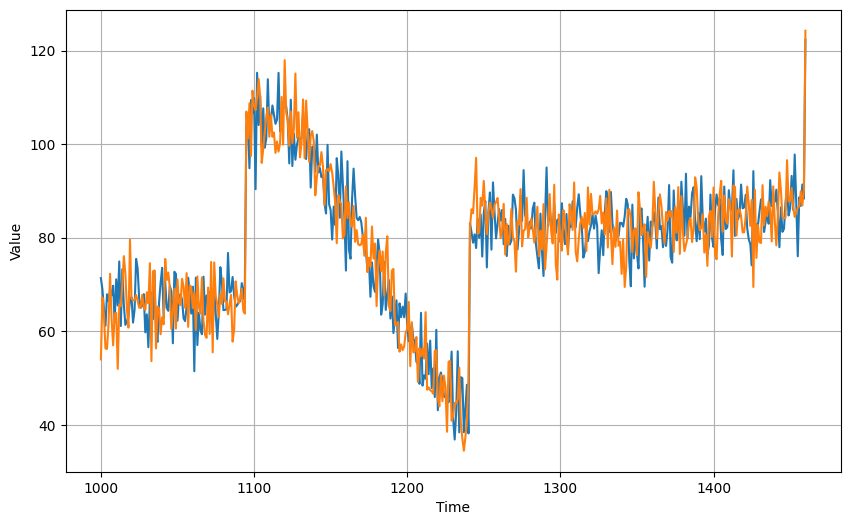

In [26]:
# 1년 주기의 seasonality가 있다고 가정하고 제거해주자.
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

# plot_series(diff_time, diff_series)

# 그리고 30일 이동 평균법을 때리고,
diff_moving_avg = moving_average_forecast(diff_series, 30)

# 시간을 맞춰주고,
diff_moving_avg = diff_moving_avg[split_time - 365 - 30:]
# diff_series = diff_series[split_time - 365:]
# plot_series(time_valid, (diff_series, diff_moving_avg))

# 1년 전 값에 더해만 주자.
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_past))

In [27]:
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

53.764584
5.9032416


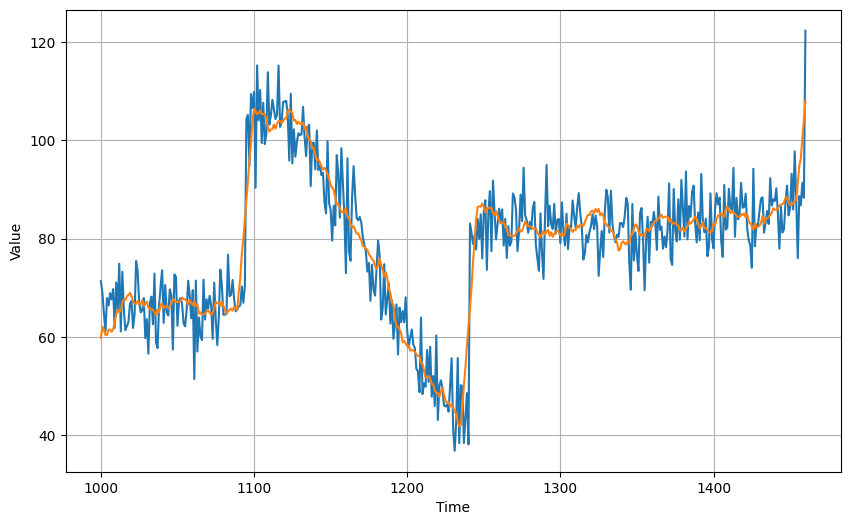

In [28]:
# Smooth the original series before adding the time differenced moving average
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

# Plot the results
plot_series(time_valid, (x_valid, diff_moving_avg_plus_smooth_past))

In [29]:
 # Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

34.315723
4.6053295
